In [6]:
from editor import Editor
from Box2D.b2 import pi

# edit your model by running this cell
# hit 's' to save while editing to model.json

editor = Editor()
editor.load('crawler.json')
editor.run()

File loaded: crawler.json
File saved as: crawler.json


In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np
from IPython.display import clear_output

import pygame
from pygame.locals import (KEYDOWN, K_RIGHT, K_LEFT, K_r, K_s, K_r)

from Box2D.b2 import pi

from agent import Agent
from engine import Engine

from time import sleep

# train your model to (hopefully) walk by running this cell
FILE = 'star.json'

# Physics engine and window
LOWER_LIM = -.4 * np.pi
UPPER_LIM = .4 * np.pi
LIMIT = False
ANGLE_RANGE = UPPER_LIM - LOWER_LIM if LIMIT else np.pi*2.0
engine = Engine(caption='Train', width=1280, height=720, gravity=(0, -50), joint_limit=LIMIT, \
               upper_angle=UPPER_LIM, lower_angle=LOWER_LIM, linear_damping=0.0, angular_damping=0)

engine.load(FILE)

# Add floor
engine.add_static_body(p=(engine.width/2, engine.height-10), size=(engine.width, 10))

# Features
ENCODING_SIZE = 32 # buckets for body angles

def features():
    f = []
    
    for b in engine.world.bodies:
        if b.userData and isinstance(b.userData, dict):
            a = b.angle % ANGLE_RANGE
            a /= ANGLE_RANGE
            a = int(a * ENCODING_SIZE)
            encoding = [0] * ENCODING_SIZE
            encoding[a] = 1.0
            f.extend(encoding)
    
    """
    for b in engine.world.bodies:
        if b.userData and isinstance(b.userData, dict):
            a = b.angle % ANGLE_RANGE
            a /= ANGLE_RANGE
            a = a * 2.0 - 1.0
            f.append(a)"""
            
    #for j in engine.world.joints:
    #    f.append(j.motorSpeed)
                
    return np.array([f])

# all joints change
def act(torques):
    # torques list of engine torques
    # joint config:
    for i, t in enumerate(torques):
        engine.world.joints[i].motorSpeed = t
    
def body_position():
    avg = np.zeros([2])
    cnt = 0
    for b in engine.world.bodies:
        if b.userData:
            avg += [b.position[0], b.position[1]]
            cnt += 1
    avg /= cnt
    return engine.to_screen(avg)

def set_position(position, zero_vel=True):
    current = engine.to_pybox2d(body_position())
    position = engine.to_pybox2d(position)
    shift = (position[0] - current[0], position[1] - current[1])
    for b in engine.world.bodies:
        if b.userData:
            if zero_vel:
                b.linearVelocity = (0, 0)
                b.angularVelocity = 0
            b.position = (b.position[0] + shift[0], b.position[1] + shift[1])

body_count = len(engine.world.bodies) - 1
joint_count = len(engine.world.joints)
action_count = 2**joint_count

if body_count == 0 or joint_count == 0:
    engine.close()
    raise ValueError("Your model doesn't have any physics bodies or joints")

W = np.random.randn(features().shape[1], joint_count)
def torques(state):
    return np.tanh(state.dot(W))

rs = []
avg_r = 0.0

speedup = False
running = True
while running:
    
    # train
    clear_output(wait=True)
    fig = plt.plot(rs, 'b')
    plt.plot([0, len(rs)], [0, 0], 'r')
    plt.show()
    sleep(1)
        
    t = 0
    
    engine.clear_all_but_ground()
    engine.load(FILE)
    
    last_x = body_position()[0]
    
    s1 = features()
    a1 = torques(s1)[0]
    
    reset = False
    while not reset:
        for event in engine.events():
            if engine.quit_event(event):
                running = False
                reset = True
            if event.type == KEYDOWN:
                k = pygame.key.get_pressed()
                if k[K_RIGHT]:
                    agent.eps += .1
                elif k[K_LEFT]:
                    agent.eps -= .1
                elif k[K_r]:
                    reset = True
                elif k[K_s]:
                    speedup = not speedup

        # build xp tuple
        xp = {'s1': s1.copy(), 'a1': a1.copy()}

        # act a1
        act(a1)
        
        # step physics engine multiple times
        engine.step_physics(1)

        # reward move right relative
        reward = body_position()[0] - last_x
        #reward *= -1
        
        xp['r'] = reward
        
        # train neural network
        W *= 0.99998
        W += np.multiply(s1.T, a1) * reward * .05
        
        avg_r += .001 * (reward - avg_r)
        rs.append(avg_r)
                             
        # state2
        s2 = features()
        a2 = torques(s2)[0]

        xp['s2'] = s2.copy()
        xp['a2'] = a2.copy()
        
        if not speedup:
            clear_output(wait=True)
            print(t)
            engine.render()
            engine.clock_tick()
            #fig = plt.plot(a2)
            #plt.show()

        # prepare for next rounds
        s1 = s2
        a1 = a2
        last_x = body_position()[0]
        t += 1

        if last_x > engine.width-50.0 or last_x < 50.0:
            reset = True
            engine.render()
            engine.clock_tick()

engine.close()

533


KeyboardInterrupt: 

In [ ]:
features -> motor_torques

gradient is full product * reward

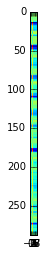

In [3]:
fig = plt.imshow(W)